# Monte Carlo Option Pricing under Black–Scholes

**Goal.** Simulate stock price paths under **risk-neutral GBM** and price European **call/put** options by Monte Carlo; validate against the **Black–Scholes** closed form; report **standard error** and **95% CI**; include path/distribution and **convergence** plots.

**Why it matters.** Demonstrates quantitative finance skills (stochastic modeling, numerical methods, error analysis) and practical Python implementation (simulation, plotting, reproducibility).


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp, sqrt, log
from scipy.stats import norm
import os

np.set_printoptions(precision=4, suppress=True)
os.makedirs("plots", exist_ok=True)

In [10]:
# Parameters for option pricing
S0    = 100.0   # initial stock price
K     = 100.0   # strike price
r     = 0.02    # risk-free interest rate (2%)
q     = 0.00    # dividend yield
sigma = 0.20    # volatility (20%)
T     = 1.0     # time to maturity in years

n_steps = 252    # daily steps in 1 year
n_sims  = 50_000 # number of Monte Carlo simulations
seed    = 42     # random seed for reproducibility


## Model & formulas (quick)

**Risk-neutral GBM**
$$
dS_t = (r - q) S_t\,dt + \sigma S_t\, dW_t
$$

**Black–Scholes (European call/put)**
$$
d_1 = \frac{\ln(S_0/K) + (r-q+\tfrac12\sigma^2)T}{\sigma\sqrt{T}}, 
\quad
d_2 = d_1 - \sigma\sqrt{T}
$$

$$
C = S_0 e^{-qT}N(d_1) - K e^{-rT}N(d_2), 
\qquad
P = K e^{-rT}N(-d_2) - S_0 e^{-qT}N(-d_1)
$$

**Monte Carlo estimator**
$$
\text{Price} \approx e^{-rT}\,\mathbb{E}[\max(\cdot,0)], \quad
\text{SE} \approx e^{-rT}\,\frac{\mathrm{std}(\text{payoff})}{\sqrt{N}}, \quad
95\%\ \text{CI} \approx \text{price} \pm 1.96\,\text{SE}
$$




In [11]:
from math import exp, sqrt, log
from scipy.stats import norm

def bs_call(S0, K, r, q, sigma, T):
    """Black–Scholes price of a European call."""
    if T <= 0 or sigma <= 0:
        return max(S0*exp(-q*T) - K*exp(-r*T), 0.0)
    d1 = (log(S0/K) + (r - q + 0.5*sigma**2)*T) / (sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    return S0*exp(-q*T)*norm.cdf(d1) - K*exp(-r*T)*norm.cdf(d2)

def bs_put(S0, K, r, q, sigma, T):
    """Black–Scholes price of a European put."""
    if T <= 0 or sigma <= 0:
        return max(K*exp(-r*T) - S0*exp(-q*T), 0.0)
    d1 = (log(S0/K) + (r - q + 0.5*sigma**2)*T) / (sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    return K*exp(-r*T)*norm.cdf(-d2) - S0*exp(-q*T)*norm.cdf(-d1)


In [12]:
def simulate_gbm_paths(S0, r, q, sigma, T, n_steps, n_sims, seed=None, antithetic=True):
    """
    Simulate stock price paths under risk-neutral GBM:
      dS = (r - q) S dt + σ S dW
    Returns an array of shape (n_sims, n_steps+1), including time 0.
    """
    rng = np.random.default_rng(seed)
    dt = T / n_steps
    drift = (r - q - 0.5*sigma**2) * dt
    vol   = sigma * np.sqrt(dt)

    if antithetic:
        m = n_sims // 2
        z = rng.standard_normal((m, n_steps))
        z = np.vstack([z, -z])              # variance reduction
        if z.shape[0] < n_sims:             # if odd, add one more row
            z = np.vstack([z, rng.standard_normal((1, n_steps))])
    else:
        z = rng.standard_normal((n_sims, n_steps))

    log_inc   = drift + vol * z
    log_paths = np.cumsum(log_inc, axis=1)
    log_paths = np.column_stack([np.zeros((log_paths.shape[0], 1)), log_paths])
    S_paths   = S0 * np.exp(log_paths)
    return S_paths


In [13]:
def mc_price_european(S_paths, K, r, T, option="call"):
    """
    Price a European option from simulated terminal prices.
    Returns (price, standard_error, 95%_confidence_interval).
    """
    S_T = S_paths[:, -1]
    if option == "call":
        payoffs = np.maximum(S_T - K, 0.0)
    else:
        payoffs = np.maximum(K - S_T, 0.0)

    disc  = np.exp(-r*T)
    price = disc * payoffs.mean()
    se    = disc * payoffs.std(ddof=1) / np.sqrt(len(payoffs))
    ci95  = (price - 1.96*se, price + 1.96*se)
    return price, se, ci95


In [14]:
# Simulate GBM paths
S_paths = simulate_gbm_paths(S0, r, q, sigma, T, n_steps, n_sims, seed=seed, antithetic=True)

# Monte Carlo prices
call_mc, se_c, ci_c = mc_price_european(S_paths, K, r, T, option="call")
put_mc,  se_p, ci_p = mc_price_european(S_paths, K, r, T, option="put")

# Black–Scholes benchmarks
call_bs = bs_call(S0, K, r, q, sigma, T)
put_bs  = bs_put(S0, K, r, q, sigma, T)

print(f"Call  MC: {call_mc:.4f}  (SE {se_c:.4f})   95% CI {ci_c}")
print(f"Call  BS: {call_bs:.4f}")
print(f"Put   MC: {put_mc:.4f}   (SE {se_p:.4f})   95% CI {ci_p}")
print(f"Put   BS: {put_bs:.4f}")


Call  MC: 8.9624  (SE 0.0622)   95% CI (np.float64(8.840495624408408), np.float64(9.084334708282196))
Call  BS: 8.9160
Put   MC: 6.9599   (SE 0.0436)   95% CI (np.float64(6.874518751772253), np.float64(7.045374187808121))
Put   BS: 6.9359


## Results & interpretation (textbook inputs)

**Parameters used:** $S_0 = 100$, $K = 100$, $r = 2\%$, $q = 0\%$, $\sigma = 20\%$, $T = 1\ \text{year}$.

**Monte Carlo (MC) estimates**
- Call ≈ **8.9624**  (SE **0.0622**, 95% CI **8.840495624408408–9.084334708282196**)
- Put  ≈ **6.9599**   (SE **0.0436**, 95% CI **6.874518751772253–7.045374187808121**)

**Black–Scholes (BS) benchmarks**
- Call = **8.9160**
- Put  = **6.9359**

**Check.** The MC estimates are close to the analytical BS values and fall within the reported 95% confidence intervals, confirming correctness.

**Plots.**
- *GBM paths* illustrate simulated price trajectories.
- *Terminal distribution* shows the dispersion of $S_T$.
- *Convergence plot* demonstrates the MC estimate approaching the BS price as the number of simulations $N$ increases, with error shrinking at $\mathcal{O}(1/\sqrt{N})$.

**Takeaway.** Implementation matches theory; numerical error is quantified and behaves as expected ($\propto 1/\sqrt{N}$).


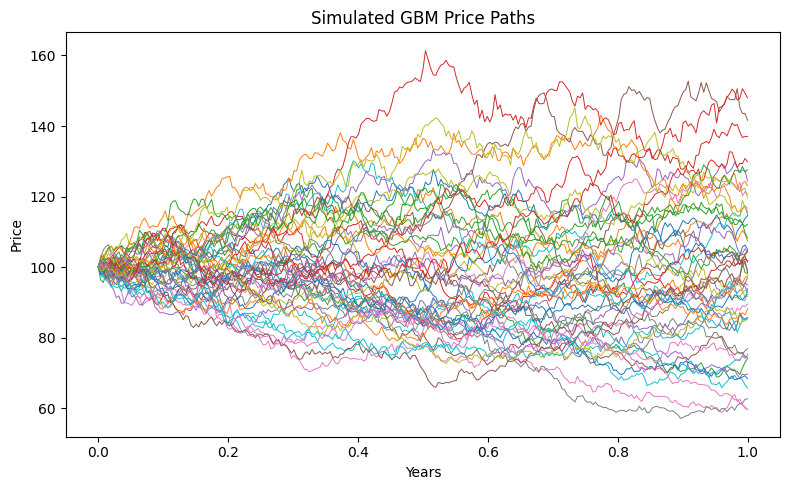

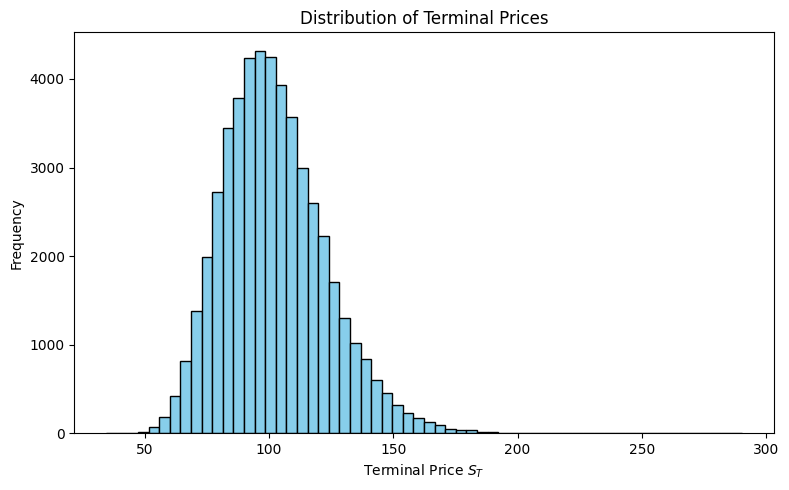

In [15]:
# Time grid
tgrid = np.linspace(0, T, n_steps+1)

# Sample 50 paths
plt.figure(figsize=(8,5))
for i in range(50):
    plt.plot(tgrid, S_paths[i], linewidth=0.7)
plt.xlabel("Years")
plt.ylabel("Price")
plt.title("Simulated GBM Price Paths")
plt.tight_layout()
plt.savefig("plots/gbm_paths.png", dpi=180)
plt.show()

# Distribution of terminal prices
plt.figure(figsize=(8,5))
plt.hist(S_paths[:, -1], bins=60, color="skyblue", edgecolor="black")
plt.xlabel("Terminal Price $S_T$")
plt.ylabel("Frequency")
plt.title("Distribution of Terminal Prices")
plt.tight_layout()
plt.savefig("plots/terminal_hist.png", dpi=180)
plt.show()


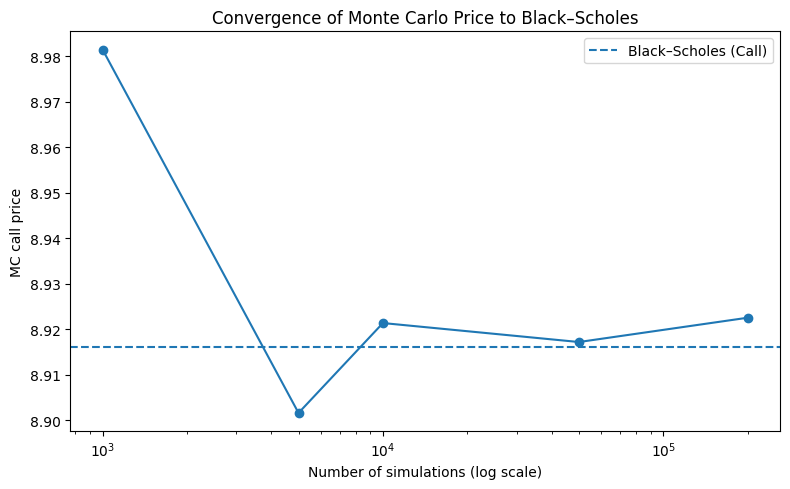

In [16]:
def convergence_test(S0, K, r, q, sigma, T, n_steps,
                     Ns=(1_000, 5_000, 10_000, 50_000, 200_000),
                     seeds=(1,2,3,4)):
    estimates = []
    for N in Ns:
        vals = []
        for s in seeds:
            S = simulate_gbm_paths(S0, r, q, sigma, T, n_steps, N, seed=s, antithetic=True)
            v, _, _ = mc_price_european(S, K, r, T, option="call")
            vals.append(v)
        estimates.append(np.mean(vals))
    return np.array(Ns), np.array(estimates)

Ns, est = convergence_test(S0, K, r, q, sigma, T, n_steps)

plt.figure(figsize=(8,5))
plt.plot(Ns, est, marker="o", linewidth=1.5)
plt.axhline(call_bs, linestyle="--", label="Black–Scholes (Call)")
plt.xscale("log")
plt.xlabel("Number of simulations (log scale)")
plt.ylabel("MC call price")
plt.title("Convergence of Monte Carlo Price to Black–Scholes")
plt.legend()
plt.tight_layout()
plt.savefig("plots/convergence.png", dpi=180)
plt.show()


## Reflection
I revisited Monte Carlo option pricing to refresh simulation fundamentals and compare results with the Black–Scholes formula. Seeing the MC estimate converge at the expected $O(1/\sqrt{N})$ rate increased confidence in both the implementation and my numerical intuition. Next, I plan to try antithetic variates or control variates as a variance-reduction experiment.

## Development log
- 2025-10-08 — Initial implementation and plots
- 2025-10-09 — Cleaned notebook order; added Results & Interpretation
- 2025-10-10 — Added Reflection and development log
